# Moosic Model :: Iteration v1 - test



* combining datasets as done prior [data preprocessing][data management]
* train test split [modelling]
* baseline model [discussion needed]
* baseline model sketch and implementation


## Importing required libraries




In [ ]:


# IMPORT LIBRARIES


try:

    import numpy as np
    import pandas as pd
    import random as rnd
    #from tqdm.notebook import tqdm as tqdm
    from tqdm import tqdm 
    #from .autonotebook import tqdm as notebook_tqdm
    import time

    # databases - sql
    #from dotenv import dotenv_values
    #import sqlalchemy

    # visualisation
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    # split data - avoid data leakage
    from sklearn.model_selection import train_test_split


    # cross validation, hyperparameter tuning
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV, KFold
    from sklearn.model_selection import cross_val_score

    # preprocessing, scaling
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler

    # modelling - clustering
    from sklearn.cluster import KMeans, MiniBatchKMeans
    from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

    # text converter/ vectorizer
    from sklearn.feature_extraction.text  import TfidfVectorizer

    # modelling - classification
    from xgboost import XGBClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    from sklearn.svm import SVC
    from sklearn.svm import LinearSVC
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
    from sklearn.ensemble import VotingClassifier, StackingClassifier
    from sklearn.linear_model import LogisticRegression

    # high dimensional usage - dimensionality reduction
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA

    # metrics
    from sklearn import metrics
    from sklearn.metrics import euclidean_distances, silhouette_score
    from sklearn.metrics.pairwise import linear_kernel,sigmoid_kernel, cosine_similarity
    from sklearn.metrics import pairwise_distances # pairwise_distances_argmin
    from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve

    # pipeline
    from sklearn.pipeline import Pipeline
    from sklearn.pipeline import make_pipeline





except ImportError as error:
    print(f"Installation of the required dependencies necessary! {error}")

    %pip install numpy
    %pip install pandas
    #%pip install dotenv
    #%pip install sqlalchemy
    %pip install seaborn
    %pip install matplotlib
    %pip install scikit-learn
    %pip install xgboost
    %pip install tqdm
    %pip install ipywidgets
    %pip install yellowbrick  

    print(f"Successful installation of the required dependencies necessary")


import warnings
warnings.filterwarnings('ignore')





# color scheme

- custom_palette = { violet: #2B2960, blue: #00A1D8, orange: #F08144, yellow: #FDC20C, green: #29A744, eggshell: #FFF4D5}


- custom_palette =[#2B2960, #00A1D8, #F08144, #FDC20C, #29A744, #FFF4D5]



In [ ]:




# setting color scheme 


#custom_palette = sns.color_palette(['#2B2960', '#00A1D8', '#F08144', '#FDC20C', '#29A744', '#FFF4D5']) #hexcode
#custom_palette_rgb = sns.color_palette(['(43, 41, 96, 1.0)', '(0, 161, 216, 1.0)', '(240, 129, 68, 1.0)', '(253, 194, 12, 1.0)', '(41, 167, 68, 1.0)', '(255, 244, 213, 1.0)']) #rgba values of the hexcodes above

#colors = ListedColormap(custom_palette)

#colors_hex = sns.set_palette(custom_palette)
hex_colors = ['#2B2960', '#00A1D8', '#F08144', '#FDC20C', '#29A744', '#22E87E', '#FFF4D5', '#E3CFBF']
custom_cmap_hex = ListedColormap(sns.color_palette(hex_colors).as_hex())


custom_palette = sns.set_palette(sns.color_palette(hex_colors))



custom_cmap_hex

# pandas plot: colormap = custom_cmap_hex, plt/sns plot : cmap = custom_cmap_hex



In [ ]:
hex_colors1 = ['#2B2960', '#00A1D8', '#F08144', '#FDC20C', '#29A744', '#22e87E', '#FFF4D5', '#E3CFBF']
custom_cmap_hex1 = ListedColormap(sns.color_palette(hex_colors1).as_hex())

custom_cmap_hex1 


In [ ]:
# setting color scheme for plots


hex_colors = ['#2B2960', '#00A1D8', '#F08144', '#FDC20C', '#29A744', '#22e87E', '#FFF4D5', '#E3CFBF']

custom_palette = sns.set_palette(sns.color_palette(hex_colors))

# pandas plot: colormap = custom_cmap_hex, plt/sns plot : cmap = custom_cmap_hex

custom_palette 


## Loading the data

In [ ]:
# load the data files for moosic


df_musgenre = pd.read_csv('../data/processed/df_with_main_genres_v1.csv', low_memory=False)

# get shape of the artist and tracks dataframe

print(f"Music data: There are {df_musgenre.shape[0]} observations and {df_musgenre.shape[1]} feature variables ")
print('----------'*10)

df_musgenre.head(2)

In [ ]:


moosic_data = df_musgenre.copy(deep=True)
moosic_data = moosic_data.query("main_genres != '[]' ").reset_index(drop=True)
moosic_data = moosic_data.convert_dtypes()

null_rows = moosic_data[moosic_data.isnull().T.any()].index
moosic_data = moosic_data.drop(null_rows)

print(moosic_data.isnull().T.any())
print(moosic_data.shape)

moosic_data.head(2)



In [ ]:
moosic_data['main_genres'].unique()



In [ ]:
# from one_genre_each_song.ipynb


# Create an empty list to hold rows
rows_list = []

# Iterate through each row in the original DataFrame
for index, row in moosic_data.iterrows():
    # Get the list of genres in the 'main_genres' column
    genres_list = eval(row['main_genres'])  # Convert the string representation to a list
    
    # Iterate through each genre in the list and create a new row
    for genre in genres_list:
        # Create a copy of the row and update the 'main_genres' column with the current genre
        new_row = row.copy()
        new_row['core_genres'] = genre #changed here to core_genres because we already have main_genres column
        
        # Append the new row to the list
        rows_list.append(new_row)

# Create a new DataFrame from the list of rows
moosic_data = pd.DataFrame(rows_list)



In [ ]:
# Count the number of songs for each unique genre
genre_counts = moosic_data['core_genres'].value_counts()

# Count the total number of unique genres
num_unique_genres = len(genre_counts)

# Print the number of unique genres and the number of songs for each genre
print("Number of Unique Genres:", num_unique_genres)
print("\nNumber of Songs for Each Genre:")
print(genre_counts)

In [ ]:
# Check for empty values in the entire DataFrame
empty_values = moosic_data.isna().sum()

# Print the number of empty values for each column
print("Empty Values in Each Column:")
print(empty_values)

In [ ]:
# drop null/empty rows

null_rows1 = moosic_data[moosic_data.isnull().T.any()].index
moosic_data = moosic_data.drop(null_rows1)
empty_values = moosic_data.isna().sum()
print(empty_values)

In [ ]:
# current features for moosic data

features = moosic_data.columns.tolist()
features



In [ ]:
# save current moosic (mood-music) dataset : removed nulls and empty lists

#moosic_data.to_csv('../data/processed/moosic_data.csv', chunksize=len(moosic_data)//5, index=False)





![1](https://www.researchgate.net/profile/Angelo-Ciaramella/publication/263964114/figure/fig1/AS:566286145867776@1512024546717/Two-dimensional-emotion-representation-in-Thayers-model.png)
[ 1](https://www.researchgate.net/figure/Two-dimensional-emotion-representation-in-Thayers-model_fig1_263964114/download?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6Il9kaXJlY3QiLCJwYWdlIjoiX2RpcmVjdCJ9fQ)


![2](https://www.researchgate.net/profile/Sarfaraz-Masood/publication/309648785/figure/fig1/AS:424403734405121@1478197143294/Thayers-2-D-Emotion-Model.png)
[ 2](https://www.researchgate.net/publication/309648785_MFCC_Spectral_and_Temporal_Feature_based_Emotion_Identification_in_Songs)





### Circumplex model of affect (mood) - Russell 2-D model formula

* valence = radius (lenght) x cos(angle of affect term)
* energy = radius (lenght) x sin(angle of affect term)


### Plutchik's wheel of affect/Emotions + Circumplex

* mood_indicators = (valence , energy) = (r.cos(theta) , r.sin(theta)) 
  - the radius = 0.5
  - the origin = (0.5, 0.5)
  - theta = angle of affect for mood
  - proposed affect-mood sub-quadrants thetas : happy (0°), euphoric (45°), tense (90°), angry (135°), depressive (180°), sad (225°), calm (270°), relaxed (315°).
* our data for both variables lie between the range 0 and 1 so 

* given the fact that we have the valence and energy values already, we can calculate the 8 basic moods for the model with:
 - theta = arctan2( energy, valence) - the arctangent when given for 2 parameters

* 8 basic mood quadrants and sub-quadrants : 8 mood co-ordinates (4 main quadrants) for the 8 basic moods 
    - Quadrants : 
        - Q1 (Happy/Exuberant)  : [(0.5, 1.0), (0.5, 1.0)], # high valence, high energy
        - Q2 (Anger/anxious)   : [(0.0, 0.5), (0.5, 1.0)], # low valence, high energy
        - Q3(Sad/depressed)        : [(0.0, 0.5), (0.0, 0.5)], # low valence, low energy
        - Q4 (Relaxed/Content/calm) : [(0.5, 1.0), (0.0, 0.5)], # high valence, low energy 

    <br>

  - Sub-quadrants (using the polar method) : * not in use here, need to obtain the vertices of the triangles in each quadrant, so using the other to save time
    - Q1 (Happy)  : M1 - happy [r.cos(0°), r.sin(0°)],  M2 - euphoric [r.cos(45°), r.sin(45°)] 
    - Q2 (Angry)  : M3 - tense [r.cos(90°), r.sin(90°)],  M4 - angry [r.cos(135°), r.sin(135°)] 
    - Q3 (Sad) : M5 - depressive [r.cos(180°), r.sin(180°)],  M6 - sad [r.cos(225°), r.sin(225°)]
    - Q4 (Relaxed)  : M7 - calm [r.cos(270°), r.sin(270°)],  M8 - relaxed [r.cos(315°), r.sin(315°)] 




  - Sub-quadrants (modified-russell-thayer): 
    - Q1 (Happy)  : M1 - happy [(0.5, 1.0), (0.5, 0.75)],  M2 - euphoric [(0.5, 1.0), (0.75, 1.0)] 
    - Q2 (Angry)  : M3 - tense [(0.0, 0.5), (0.75, 1.0)],  M4 - angry [(0.0, 0.5), (0.5, 0.75)]
    - Q3 (Sad) : M5 - depressive [(0.0, 0.5), (0.25, 0.5)],  M6 - sad [(0.0, 0.5), (0.0, 0.25)]
    - Q4 (Relaxed)  : M7 - calm [(0.5, 1.0), (0.0, 0.25)],  M8 - relaxed [(0.5, 1.0), (0.0, 0.25)]
  

 so, using the valence and energy values we have for the affect terms listed in the mood_labels variable to calculate the angle it lies on the circumplex 2d graph using the russell 2-d valence and arousal 8 (energy) formula we get

```python 

# quadrants
mood_quadrants = {
                    'Q1 (Happy/Exuberant)'  : [(0.5, 1.0), (0.5, 1.0)], # high valence, high energy
                    'Q2 (Angry/anxious)'   : [(0.0, 0.5), (0.5, 1.0)], # low valence, high energy                  
                    'Q3(Sad/depressed)'        : [(0.0, 0.5), (0.0, 0.5)], # low valence, low energy
                    'Q4 (Relaxed/Content/calm)' : [(0.5, 1.0), (0.0, 0.5)] # high valence, low energy

}



# 1D : subquadrants (valence)

mood_sub_quadrants = {
                        'happy' : [0.875, 1.0),
                        'euphoric' : [0.875, 1.0),                 
                        'tense' : [0.875, 1.0),
                        'angry' :[0.875, 1.0),
                        'depressed' : [0.0, 0.125),
                        'sad' :[0.125, 0.25),
                        'calm' : [0.875, 1.0),
                        'relaxed' : [0.875, 1.0),

    }

# 2D : subquadrants (valence & energy)

mood_sub_quadrants = {
                        'happy' : [(0.5, 1.0), (0.5, 0.75)],
                        'euphoric' : [(0.5, 1.0), (0.75, 1.0)],                  
                        'tense' : [(0.0, 0.5), (0.75, 1.0)], 
                        'angry' :[(0.0, 0.5), (0.5, 0.75)], 
                        'depressed' : [(0.0, 0.5), (0.25, 0.5)], 
                        'sad' :[(0.0, 0.5), (0.0, 0.25)], 
                        'calm' : [(0.5, 1.0), (0.0, 0.25)], 
                        'relaxed' : [(0.5, 1.0), (0.25, 0.5)]

    }


```







In [ ]:


# quadrants
mood_quadrants = {
                    'Q1 (Happy/Exuberant)'  : [(0.5, 1.0), (0.5, 1.0)], # high valence, high energy
                    'Q2 (Angry/anxious)'   : [(0.0, 0.5), (0.5, 1.0)], # low valence, high energy                  
                    'Q3(Sad/depressed)'        : [(0.0, 0.5), (0.0, 0.5)], # low valence, low energy
                    'Q4 (Relaxed/Content/calm)' : [(0.5, 1.0), (0.0, 0.5)] # high valence, low energy

}


# 1D : subquadrants (valence)

mood_1sub_quadrants = {
                        'happy' : (0.875, 1.0),
                        'euphoric' : (0.875, 1.0),                 
                        'tense' : (0.875, 1.0),
                        'angry' :(0.875, 1.0),
                        'depressed' : (0.0, 0.125),
                        'sad' :(0.125, 0.25),
                        'calm' : (0.875, 1.0),
                        'relaxed' : (0.875, 1.0),

    }

# for the 2d cartesian plot based on valence and energy
# The list of tuples represents the quadrants in which the core 8 moods dominate

# 2D : subquadrants (valence & energy)

mood_2sub_quadrants = {
                        'happy' : [(0.5, 1.0), (0.5, 0.75)],
                        'euphoric' : [(0.5, 1.0), (0.75, 1.0)],                  
                        'tense' : [(0.0, 0.5), (0.75, 1.0)], 
                        'angry' :[(0.0, 0.5), (0.5, 0.75)], 
                        'depressed' : [(0.0, 0.5), (0.25, 0.5)], 
                        'sad' :[(0.0, 0.5), (0.0, 0.25)], 
                        'calm' : [(0.5, 1.0), (0.0, 0.25)], 
                        'relaxed' : [(0.5, 1.0), (0.25, 0.5)]

    }


In [ ]:


# mood maps for 1d and 2d


def mood_map(data):


    valence = data['valence']
    energy = data['energy']
    
    if (valence >= 0.5 and valence <= 1.0) and (energy >= 0.5 and energy <= 1.0):
        return 'happy' #hvhe
    elif (valence >= 0.0 and valence <= 0.5) and (energy >= 0.5 and energy <= 1.0):
        return 'tense' #lvhe
    elif (valence >= 0.0 and valence <= 0.5) and (energy >= 0.0 and energy <= 0.5):
        return 'sad' #lvle
    elif (valence >= 0.5 and valence <= 1.0) and (energy >= 0.0 and energy <= 0.5):
        return 'relaxed' #hvle
    else:
        pass



def mood_2d_map(data):


    valence = data['valence']
    energy = data['energy']
    
    if (valence >= 0.5 and valence <= 1.0) and (energy >= 0.5 and energy <= 0.75):
        return 'happy'
    elif (valence >= 0.5 and valence <= 1.0) and (energy >= 0.75 and energy <= 1.0):
        return 'euphoric'
    elif (valence >= 0.0 and valence <= 0.5) and (energy >= 0.75 and energy <= 1.0):
        return 'tense'
    elif (valence >= 0.0 and valence <= 0.5) and (energy >= 0.5 and energy <= 0.75):
        return 'angry'
    elif (valence >= 0.0 and valence <= 0.5) and (energy >= 0.25 and energy <= 0.5):
        return 'depressed'
    elif (valence >= 0.0 and valence <= 0.5) and (energy >= 0.0 and energy <= 0.25):
        return 'sad'
    elif (valence >= 0.5 and valence <= 1.0) and (energy >= 0.0 and energy <= 0.25):
        return 'calm'
    elif (valence >= 0.5 and valence <= 1.0) and (energy >= 0.25 and energy <= 0.5):
        return 'relaxed'
    else:
        pass




def mood_1d_map(data):

    valence = data['valence']

    if (valence > 0.875 and valence <= 1.0):
        return 'happy'
    elif (valence > 0.75 and valence <= 0.875):
        return 'euphoric'
    elif (valence > 0.375 and valence <= 0.5):
        return 'tense'
    elif (valence > 0.25 and valence <= 0.375):
        return 'angry'
    elif (valence > 0.0 and valence <= 0.125):
        return 'depressed'
    elif (valence > 0.125 and valence <= 0.25):
        return 'sad'
    elif (valence > 0.5 and valence <= 0.625):
        return 'calm'
    elif (valence > 0.625 and valence <= 0.75):
        return 'relaxed'
    else:
        pass

moosic_data['mood_42d_label'] = moosic_data.apply(mood_map , axis=1)
moosic_data['mood_1d_label'] = moosic_data.apply(mood_1d_map, axis=1)
moosic_data['mood_goal'] = moosic_data.apply(mood_2d_map, axis=1)


moosic_data.head(3)



In [ ]:
# current features for moosic data

features = moosic_data.columns.tolist()
features

In [ ]:
moosic_data.info()


In [ ]:

moosic_data = moosic_data[features].drop(['mood_42d_label', 'mood_1d_label'], axis = 1) 



In [ ]:
# drop null/empty rows

null_rows11 = moosic_data[moosic_data.isnull().T.any()].index
moosic_data = moosic_data.drop(null_rows11)
empty_values = moosic_data.isna().sum()
print(empty_values)

In [ ]:
# current features for moosic data

features = moosic_data.columns.tolist()
features



In [ ]:
moosic_data.info()


In [ ]:
# save current moosic (mood-music) dataset : removed nulls and empty lists
# compress and send processed file to be for further analysis and modelling

#moosic_data.to_csv('../data/processed/moosic_data_processed.csv', chunksize=len(moosic_data)//5, index=False)




In [ ]:
# drop some features

moosic_data = moosic_data[features].drop(['artists_id', 'duration_ms', 'liveness', 'time_signature',
                                    'followers', 'artist_popularity', 'track_popularity','release_date',  'explicit', 'mode',
                                    'loudness'], axis = 1)

moosic_data.head()


In [ ]:
# check again

moosic_data.columns.tolist()



In [ ]:
# encode categorical data : genre 

#genre
genre2d_dummies = pd.get_dummies(moosic_data['core_genres'], drop_first=True).replace({True: 1, False: 0})
genre2d_encoded = pd.concat([moosic_data['core_genres'], genre2d_dummies], axis=1)
display(genre2d_encoded.head(2))



In [ ]:

# add labels to moosic data

moosic_data = pd.concat([moosic_data, genre2d_encoded.drop(['core_genres'], axis = 1) ], axis=1)
display(moosic_data.head(2))




In [ ]:
# get shape of the current moosic data

print(f''' 

    Processed Mood - Music (MOOSIC) data
    Number of observations : {moosic_data.shape[0]} 
    Number of feature variables : {moosic_data.shape[1]} 

    ''')

# Make data balanced for modelling purposes



In [ ]:
# dataset is unbalanced from the perspective of the associated mood 
#    get the count of how the mood is distributed wrt the data


def get_balanced_data(processed_dataset):

    ''' 
    get the count of how the mood is distributed wrt the data
        - count of tracks by each mood
        - get mood label with lowest count
        - group the data based on the mood labels (mood_goal of tracks for user)
        - get dataset with randomly selected track samples for each mood labels based on 
        the value from the least occuring mood label
        
    '''

    balanced_mood_data = pd.DataFrame()

    mood_label_counts = processed_dataset['mood_goal'].value_counts()
    least_frequent_mood_label = mood_label_counts.idxmin()
    count_least_frequent_mood_label = mood_label_counts.min()

    print(f"The mood label count {mood_label_counts} ")
    print("______"*10)

    print(f"The least frequent mood label is '{least_frequent_mood_label}' with {count_least_frequent_mood_label} features.")
    print("______"*10)

    grouped_data = processed_dataset.groupby('mood_goal')

    sample_size = 11879

    for mood_label, group in grouped_data:
        
        #print(f' getting balanced data for the mood : {mood_label} \n ')

        if len(group) >= count_least_frequent_mood_label: 
            random_rows = group.sample(count_least_frequent_mood_label, random_state=42) 
        else:
            random_rows = group  

        balanced_mood_data = pd.concat([balanced_mood_data, random_rows])

        continue

    print(f' Finished processing, data has balanced number of samples for all categories. ')

    balanced_mood_data = balanced_mood_data.reset_index(drop=True) 

    current_mood_label_counts = balanced_mood_data['mood_goal'].value_counts()
    print(f"The size of data mood label count {current_mood_label_counts} ")
    print("______"*10)

    return balanced_mood_data

##

moodsic_data = get_balanced_data(moosic_data)





In [ ]:
# info etc

print(f"-----"*10)


print(f''' 

    Processed Mood - Music (MOOSIC) data
    Number of observations : {moodsic_data.shape[0]} 
    Number of feature variables : {moodsic_data.shape[1]} 

    ''')

print(f"-----"*10)

moodsic_data.head(2)

In [ ]:
moodsic_data.info()


In [ ]:

# # saving balanced data  

# moodsic_data.to_csv('../data/processed/df_balanced_data.csv', chunksize=len(moodsic_data)//5, index=False)





---

# Splitting the dataset for modelling : 

* train, test split : splitting the data to avoid data leakage 
* drop columns = ['artist_name',  'track_name', 'genres', 'main_genres','mood_42d_label', 'mood_1d_label', 'mood_goal', 'core_genres']




In [ ]:

# get list of moosic data features

features = moodsic_data.columns.tolist()
features



In [ ]:


# defining X (input feature vectors) and Y (target output features)


X = moodsic_data[features].drop(['artist_name', 'track_id',  'track_name', 'genres', 'main_genres', 'mood_goal', 'core_genres'], axis = 1) 

Y = moodsic_data[['track_id', 'track_name', 'artist_name', 'mood_goal', 'core_genres']]


print("X (input feature vectors) ")
print("-----"*10)
display(X.head(2))

print("Y (target output features) ")
print("-----"*10)
display(Y.head(2))



In [ ]:

# splitting the dataset into train and test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, shuffle=True)



In [ ]:
# X features:  X_train, X_test
# Y features:  Y_train, Y_test


print("X train (input feature vectors) ")
print("-----"*10)
display(X_train.head(2))

print("X test (input feature vectors) ")
print("-----"*10)
display(X_test.head(2))

print("Y train (target output features) ")
print("-----"*10)
display(Y_train.head(2))
print("Y test (target output features) ")
print("-----"*10)
display(Y_test.head(2))



In [ ]:


# defining the actual y (target data - mood_goal)
# y : y_train, y_test from Y_train, Y_test

y_train = Y_train[['mood_goal']]

print("y_train (target data - mood_goal) ")
print("-----"*10)
display(y_train.head(2))


y_test = Y_test[['mood_goal']]

print("y_test (target data - mood_goal) ")
print("-----"*10)
display(y_test.head(2))

# encode categorical data : mood
y_train_dummies = pd.get_dummies(y_train['mood_goal'], drop_first=True).replace({True: 1, False: 0})
encoded_y_train = pd.concat([y_train['mood_goal'], y_train_dummies], axis=1)

y_test_dummies = pd.get_dummies(y_test['mood_goal'], drop_first=True).replace({True: 1, False: 0})
encoded_y_test = pd.concat([y_test['mood_goal'], y_test_dummies], axis=1)


print("encoded target (train) data - mood_goal ")
print("-----"*10)
display(encoded_y_train.head(2))


print("encoded target (test) data - mood_goal ")
print("-----"*10)
display(encoded_y_test.head(2))





In [ ]:
# reset indexes and take a sample_size = 5000 

X_train = (X_train.head(5000)).reset_index(drop=True)
X_test = (X_test.head(5000)).reset_index(drop=True)
Y_train = (Y_train.head(5000)).reset_index(drop=True)
Y_train = (Y_test.head(5000)).reset_index(drop=True)
y_train = (y_train['mood_goal'].head(5000)).reset_index(drop=True)
y_test = (y_test['mood_goal'].head(5000)).reset_index(drop=True)
encoded_y_train = (encoded_y_train.head(5000)).reset_index(drop=True)
encoded_y_test = (encoded_y_test.head(5000)).reset_index(drop=True)




In [ ]:


## saving X, Y and y 

# X.to_csv('../data/processed/X_balanced_data.csv', chunksize=len(X)//5, index=False)
# y.to_csv('../data/processed/y_balanced_data.csv', chunksize=len(y)//5, index=False)


## load data

# X_data  = pd.read_csv('../data/processed/X_balanced_data.csv', low_memory=False)
# Y_data = pd.read_csv('../data/processed/Y_balanced_data.csv', low_memory=False)



---
# Modelling

* elbow method
* dimensionality reduction / visualization of clusters in lower (2d) dimension
* clustering
* (?!)visualization of clusters in lower (2d) dimension
* prediction/classification (multi-class classification) models ... multi-label?
* recommender :top n = 5 based on item-item similarity computation based on clustering


---

In [ ]:

def optimal_cluster_plot(data, tsne=True):

    wcss_inertias = []

    if tsne == True:
        tsne = TSNE(n_components=2)
        data = tsne.fit_transform(data)

    else:
        data = data

    for k in range(4, 20):
        model = MiniBatchKMeans(n_clusters=k)
        model.fit(data)
        wcss_inertias.append(model.inertia_)
        
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(range(4, 20), wcss_inertias, '-o')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS : Within clusters sum of squares')
    plt.title('Elbow method to determine optimal K number of clusters')
    plt.xticks(range(4, 20))
    plt.show(); 








In [ ]:

# optimal number of clusters using elbow method analysis to compare with the researched  basic number of moods for music (8)

optimal_cluster_plot(X_train, tsne=True)



In [ ]:
data = X_train[['valence',  'energy']]
optimal_cluster_plot(data, tsne=True)

In [ ]:
# without tsne

optimal_cluster_plot(X_train, tsne=False)

In [ ]:

# function clustering model (+ tsne) 


def clustering_model(data,  pca = True, tsne=True, params = {'n_clusters': 8}, sample_size=5000, *args, **kwargs):


    data = data.head(sample_size)
    scaled_data = MinMaxScaler().fit_transform(data)
    data_col = data.columns.to_list()
    data = pd.DataFrame(scaled_data, columns = data_col)

    if pca == True:
        pca = PCA(n_components=2, random_state = 42)

        pca_start_time = time.time()

        data = MinMaxScaler().fit_transform(pca.fit_transform(data))

        pca_end_time = time.time()
        pca_train_time = pca_end_time - pca_start_time
        print(f"Time taken for dimensionality reduction using PCA: {pca_train_time:.2f} seconds")

        data = pd.DataFrame(data, columns = ['dimension_0', 'dimension_1'])

    else:
        data = data


    model = MiniBatchKMeans(**params)

    kme_start_time = time.time()

    data['cluster_labels'] = model.fit_predict(data)

    kme_end_time = time.time()
    kme_train_time = kme_end_time - kme_start_time
    print(f"Time taken for clustering using Mini-Batch K-Means: {kme_train_time:.2f} seconds")

    cluster_labels = model.labels_ 
    cluster_centers = model.cluster_centers_ 

    if tsne == True:
        tsne = TSNE(n_components=2, random_state = 42)

        tsne_start_time = time.time()

        tsne_embeddings = tsne.fit_transform(data)

        tsne_end_time = time.time()
        tsne_train_time = tsne_end_time - tsne_start_time
        print(f"Time taken for the computation of clustered data embeddings using t-SNE: {tsne_train_time:.2f} seconds")

    else:
        data = data

    
    
    # kp_model_name = "minikmeans.pickle"
    # tp_model_name = "tsne_embed.pickle"

    # pickle.dump(model, open(kp_model_name, 'wb'))
    # pickle.dump(model, open(tp_model_name, 'wb'))


    # kj_model_name = "minikmeans.joblib"
    # tj_model_name = "tsne_embed.joblib"

    # joblib.dump(model, kj_model_name)
    # joblib.dump(model, tj_model_name)



    return data, tsne_embeddings, cluster_labels, cluster_centers






In [ ]:
# checking clustered data features

clustered_data, clustered_embeddings, cluster_labels, cluster_centers = clustering_model(X_train,  pca = False, tsne = True, 
                                                                        params = {'n_clusters': 8}, sample_size = 5000)

clustered_data.head(2)

In [ ]:
# baseline: recommendation based on predictions of music track (mood-genre groups) and recommendation
# - mood labels are labeled encoded (but may introduce ordering bias)
## * --> np.unique(y_train['mood_2d_label'].copy()) = ['angry' 'calm' 'depressed' 'euphoric' 'happy' 'relaxed' 'sad' 'tense']
## * --> np.unique(LabelEncoder().fit_transform(y_train[['mood_2d_label']]).copy()) = array([0, 1, 2, 3, 4, 5, 6, 7])
## * --> np.concatenate([b, c]).tolist() =  ['angry','calm','depressed','euphoric','happy','relaxed','sad','tense',0,1,2,3,4,5,6,7]
#mood_list_types = ['angry','calm','depressed','euphoric','happy','relaxed','sad','tense', 0, 1, 2, 3, 4, 5, 6, 7]


baseline_cluster_params = {
    'n_clusters' : 8,
    'batch_size' : 500,
    'random_state' : 42,
    'init' : 'k-means++' #random
}

# recommend top N = 5 or random N = 5 music track based on user preferences
def baseline_recommender(x_train, y_train, playlist_length= 5, mood_clusters = mood_2sub_quadrants, cluster_params = baseline_cluster_params,
                        pca=False, tsne=True, sample_size = 5000, user_preferences = {'mood goal': 'relaxed', 'preferred_genre': 'hip hop'}, *args, **kwargs):


    recommender_start_time = time.time()

    # clustering with mini-batch kmeans 
    clustered_data, clustered_embeddings, cluster_labels, cluster_centers = clustering_model(x_train,  pca = pca, tsne = tsne, 
                                                                        params = cluster_params, sample_size = sample_size)

    #feature matrix of one-hot encoded cluster representation
    feature_matrix = np.eye(cluster_params['n_clusters'])[cluster_labels]

    #track_similarity_matrix = 1 - pairwise_distances(clustered_data, cluster_centers, metric='cosine')



    print("________"*20)
    print("________"*20)

    # visualize the clustered data
    plt.figure(figsize = (16, 10))

    scaled_embed = MinMaxScaler().fit_transform(clustered_embeddings)
    plt.scatter(scaled_embed[:, 0], scaled_embed[:, 1], c=cluster_labels, cmap=custom_cmap_hex1)
    #plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', color='black') 

    #for cluster_centerx, cluster_centery in zip(cluster_centers[:, 0], cluster_centers[:, 1]):

    #    plt.scatter(cluster_centerx, cluster_centery, marker='X', color='black') 


    plt.legend()
    plt.title('Music - Mood Clustered Data ', pad=15, fontsize = 20, weight = 'bold', color='#2B2960')
    plt.colorbar()

    get_axes = plt.gca()
    #plt.xticks([]) 
    #plt.yticks([]) 
    xax = get_axes.axes.get_xaxis()
    xax = xax.set_visible(False)

    yax = get_axes.axes.get_yaxis()
    yax = yax.set_visible(False)

    plt.show()
    #plt.savefig('../images/kclusters_count_plot.png', transparent=True)

    # recommender: query data based on user's preferences and clustered data


    y_train_classes = np.unique(y_train['mood_goal'].copy())
    y_train_classes_encoded = LabelEncoder().fit_transform(y_train[['mood_goal']]).copy()
    mood_list_types = np.concatenate([y_train_classes, np.unique(y_train_classes_encoded)]).tolist()

    y_train['mood_label'] = y_train_classes_encoded

    final_data = pd.concat([ y_train[['track_id', 'track_name', 'artist_name', 'mood_goal', 'core_genres', 'mood_label' ]], clustered_data['cluster_labels']], axis=1)

    if (user_preferences['mood goal'] in mood_list_types): #and (user_preferences['preferred_genre'] in mood_list_types):    
        choice = mood_clusters[user_preferences['mood goal']]
        query_data = final_data.query("cluster_labels == @choice")

    else:
        raise ValueError("Input mood goal is unavailable .... specified only! ")

    print("________"*20)
    print("________"*20)


    print(f"Recommended music tracks based on {user_preferences['mood goal']}: \n ")
    print("________"*15)

    print(f" Enjoy these {playlist_length} music tracks from spotify")
    print("             "*10)

    n_mood_music = query_data.sample(n=playlist_length, random_state = 42, replace=False)

    print("________"*10)

    print(n_mood_music[['track_name','artist_name']])
    print("________"*10)
    print("________"*10)





    recommender_end_time = time.time()
    recommender_train_time = recommender_end_time - recommender_start_time
    print(f"Time taken for the recommender model : {recommender_train_time:.2f} seconds")

    print("________"*20)
    print("________"*20)

    return final_data, n_mood_music






In [ ]:
# run baseline
# - run clustering model : kmeans/ mini-batch kmeans
# - dimensionality reduction and visualization with tsne
# - query clustered data and output N = 5 recommendations
# - final data shows music track name and its associated, artist, mood goal/group, core genre, and its K clustered labels.

# mood_clusters  = {
#                         'happy' : [(0.5, 1.0), (0.5, 0.75)],
#                         'euphoric' : [(0.5, 1.0), (0.75, 1.0)],                  
#                         'tense' : [(0.0, 0.5), (0.75, 1.0)], 
#                         'angry' :[(0.0, 0.5), (0.5, 0.75)], 
#                         'depressed' : [(0.0, 0.5), (0.25, 0.5)], 
#                         'sad' :[(0.0, 0.5), (0.0, 0.25)], 
#                         'calm' : [(0.5, 1.0), (0.0, 0.25)], 
#                         'relaxed' : [(0.5, 1.0), (0.25, 0.5)]

#     }


mood_clusters  = {
                        'happy' : 4,
                        'euphoric' : 3,                  
                        'tense' : 7, 
                        'angry' :0, 
                        'depressed' : 2, 
                        'sad' :6, 
                        'calm' : 1, 
                        'relaxed' : 5

    }



final_data, n_mood_music = baseline_recommender(X_train, y_train, playlist_length= 5, mood_clusters = mood_clusters , cluster_params = baseline_cluster_params,
                            tsne=True, user_preferences = {'mood goal': 'relaxed', 'preferred_genre': 'hip hop'})


# display recommendations
n_mood_music

# initial
________________________________________________________________________________________________________________________________________________________________
Recommended music tracks based on relaxed: 
 
________________________________________________________________________________________________________________________
 Enjoy these 5 music tracks from spotify
                                                                                                                                  
________________________________________________________________________________
                             track_name        artist_name
192                   Nieve de Colombia          La Etnnia
4343          Ill String Along With You     Oscar Peterson
2552                       Jungle Blues  Jelly Roll Morton
3828                         Limbo Rock       The Ventures
1278  Plus fort que nous - Instrumental        Francis Lai
________________________________________________________________________________
________________________________________________________________________________
Time taken for the recommender model : 8.57 seconds

##




In [ ]:
# display final dataset for all clustered samples

final_data.head(2)


In [ ]:
# evaluation metrics : clustering


def cluster_evaluation_metrics(ground_truth, predictions, silhouette=True):
    
    if silhouette == False:
        clustering_metrics = [
                # (n_samples, )
                metrics.rand_score,
                metrics.fowlkes_mallows_score,
                metrics.homogeneity_score,
                metrics.completeness_score,
                metrics.v_measure_score,
                metrics.mutual_info_score,
                metrics.adjusted_rand_score,
                metrics.adjusted_mutual_info_score
            ]

        print(f"For the mini-batch kmeans clustering with:  ")

        for metric in clustering_metrics:
            score_class = metric(ground_truth.to_numpy(), predictions.to_numpy())
            print(f"{metric.__name__} of: {score_class:.2f} ")

        print('_______'*10)


    else:
        cluster_scores_metrics = [
                # (n_samples, 1)
                metrics.silhouette_score,
                metrics.calinski_harabasz_score,
            ]

        print(f"For the mini-batch kmeans clustering with:  ")

        for metric in cluster_scores_metrics:
            score_class = metric(ground_truth.to_numpy().reshape(-1,1), predictions.to_numpy().reshape(-1,1))
            print(f"{metric.__name__}  of: {score_class:.2f} ")

    print('_______'*10)






In [ ]:
# baseline : clustering and recommendation evaluation

# only on the 5 preds?
cluster_evaluation_metrics(n_mood_music['mood_label'], n_mood_music['cluster_labels'], silhouette=False)

print('_______'*10)

# score on all predicted data
cluster_evaluation_metrics(final_data['mood_label'], final_data['cluster_labels'], silhouette=False)

print('_______'*10)

# silhouette needs all 
cluster_evaluation_metrics(final_data['mood_label'], final_data['cluster_labels'], silhouette=True)







# Main model 



In [ ]:
# global variables


modelling_data = {
    
    'X_train' : X_train,
    'X_test' : X_test,
    'Y_train' : Y_train,
    'Y_test' : Y_test,
    'y_train' : y_train,
    'y_test' : y_test,
    'encoded_y_train' : encoded_y_train,
    'encoded_y_test' : encoded_y_test

    }


main_cluster_params = {
        'n_clusters' : 8,
        'batch_size' : 500,
        'random_state' : 42,
        'init' : 'k-means++' 
    }

clf_params = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [None, 3, 8, 11, 20]
    }

user_preferences = {'mood goal': 'relaxed', 'preferred_genre': 'hip hop'}

In [ ]:

# main model : recommendation based on predictions of music track (mood-genre groups) and recommendation

# idea formation :

# - mood labels are labeled encoded (but may introduce ordering bias)
# - will use get_dummies method to encode the mood categories next
# - modelling : clustering + classifying + predicting/ recommending
#   - clustering : mini-batch k-means
#   - text vectorization
#   - track to track similarity computation
#   - recommend random N = 5 (or top N = 5) music track based on user preferences

# content (track-track) recommendation system based on users mood goal and genre choice
# - track to track similarity matrix computation : linear kernel
# - query data based on user's preferences and clustered data
#   - new feature that combines user preferences (mood goal and genre) : text (tdidf) vectorizer else mood vector only
#   - vectorize the strings then  compute and store similarity scores of tracks 
# - track_similarity_matrix : track to track similarity based on associated mood and genre 
# - assign track similarity matrix scores computed back to our data
# - used linear kernel to compute similarity
# - reset and drop index, then concatenated withh clustered data to be used for the next step
# - classifying tracks based on similarity score and predicting random N = 5 samples





def moosic_recommender(modelling_data = modelling_data, playlist_length= 5, cluster_params = baseline_cluster_params,
                        pca=False, tsne=True, sample_size = 5000, user_preferences = user_preferences, *args, **kwargs):


    # data : train, test features and targets

    X_train, X_test = modelling_data['X_train'], modelling_data['X_test']
    Y_train, Y_test = modelling_data['Y_train'], modelling_data['Y_test']
    y_train, y_test = modelling_data['y_train'], modelling_data['y_test']
        
    # get dummies
    #encoded_y_train, encoded_y_test = modelling_data['encoded_y_train'], modelling_data['encoded_y_test']

    # Label encoder
    encoded_y_train, encoded_y_test = LabelEncoder().fit_transform(y_train), LabelEncoder().fit_transform(y_test)

    recommender_start_time = time.time()

    # model : clustering with mini-batch kmeans 
    clustered_data, clustered_embeddings, cluster_labels, cluster_centers = clustering_model(X_train,  pca = False, tsne = True, 
                                                                            params = main_cluster_params, sample_size = 5000)

    print("________"*20)
    print("________"*20)


    # model : to visualize the clustered data with t-sne
    plt.figure(figsize = (16, 10))

    scaled_embed = MinMaxScaler().fit_transform(clustered_embeddings)
    plt.scatter(scaled_embed[:, 0], scaled_embed[:, 1], c=cluster_labels, cmap=custom_cmap_hex1)

    plt.legend()
    plt.title('Music - Mood Clustered Data ', pad=15, fontsize = 20, weight = 'bold', color='#2B2960')
    plt.colorbar()

    get_axes = plt.gca()
    xax = get_axes.axes.get_xaxis()
    xax = xax.set_visible(False)

    yax = get_axes.axes.get_yaxis()
    yax = yax.set_visible(False)

    plt.show()


    # model recommender (classification/similarity and prediction/filter) part: 

    moosic_cluster_data = pd.concat([ Y_train, clustered_data['cluster_labels']], axis=1)
    moosic_cluster_data['mood_genre'] = moosic_cluster_data['mood_goal'] + ' ' + moosic_cluster_data['core_genres']


    ## track vectorization and track - to - track similarity computation

    tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
    track_mood_genre_vector = tfidf_vectorizer.fit_transform(moosic_cluster_data['mood_genre'])

    track_similarity_matrix = linear_kernel(track_mood_genre_vector, track_mood_genre_vector)
    track_similarity_data = pd.DataFrame(track_similarity_matrix, index=moosic_cluster_data['track_name'], columns=moosic_cluster_data['track_name'])
    track_similarity_data = track_similarity_data.reset_index(drop=True)
    track_similarity_data = track_similarity_data.rename_axis(None, axis=1)

    # features track_similarity_data
    tsd_features = track_similarity_data.columns.tolist()
    scored_track_data = pd.concat([moosic_cluster_data, track_similarity_data], axis=1)


    ## personalized computation : 
    ## - combine input text preferences on mood + genre for user - (tfidf) vectorization 
    ## - user choices to track similarty prediction and similarity score

    user_preference = " ".join(user_preferences.values())

    # query track to track similarity moosic data based on user input
    queried_user_data = scored_track_data.copy(deep = True)
    queried_user_data = (queried_user_data.query(" mood_genre == @user_preference ")).reset_index(drop=True)

    ## - sort random N mood-music tracks by predicted probability for the category entered

    moosic_randomN_idx = np.random.choice(
                            queried_user_data.index,
                            size = 5, #playlist_length,
                            replace= False #random n = 5
                            )

    recommended_moosic_playlist = queried_user_data[['track_id', 'track_name', 'artist_name']].iloc[moosic_randomN_idx]


    #print(f"Here are your mood based recommended music tracks, enjoy! \n : {display(recommended_moosic_playlist)}")


    recommender_end_time = time.time()
    recommender_train_time = recommender_end_time - recommender_start_time
    print(f"Time taken for the recommender model : {recommender_train_time:.2f} seconds")

    print("________"*20)
    print("________"*20)


    composed_variables = {
        
        # fitted cluster model
        'embedded_clustered_model' : scaled_embed,

        # vectors, similarity matrices and scores data
        'track_mood_genre_vector' : track_mood_genre_vector,
        'track_similarity_matrix' : track_similarity_matrix,
        'track_similarity_data' : track_similarity_data,

        #combined data with similarity matrix
        'scored_track_data' : scored_track_data,

        # recommended playlist random
        'user_preference' : user_preference,
        'queried_user_data' : queried_user_data,
        'recommendation_model' : track_similarity_matrix,

        'moosic_randomN_idx' : moosic_randomN_idx,
        'recommended_moosic_playlist' : recommended_moosic_playlist,

        }

    return composed_variables









In [ ]:
user_preferences = {'mood goal': 'relaxed', 'preferred_genre': 'pop'}

composed_variables = moosic_recommender(modelling_data = modelling_data, playlist_length= 5, cluster_params = main_cluster_params, 
                            pca=False, tsne=True, sample_size = 5000, user_preferences = user_preferences)

scored_track_data = composed_variables['scored_track_data']
queried_user_data = composed_variables['queried_user_data']



In [ ]:
# main 1  : clustering and track-to-track similarity computation & recommendation
# evaluation


# #



Time taken for clustering using Mini-Batch K-Means: 0.16 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time taken for the computation of clustered data embeddings using t-SNE: 10.87 seconds
________________________________________________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________________________________________________


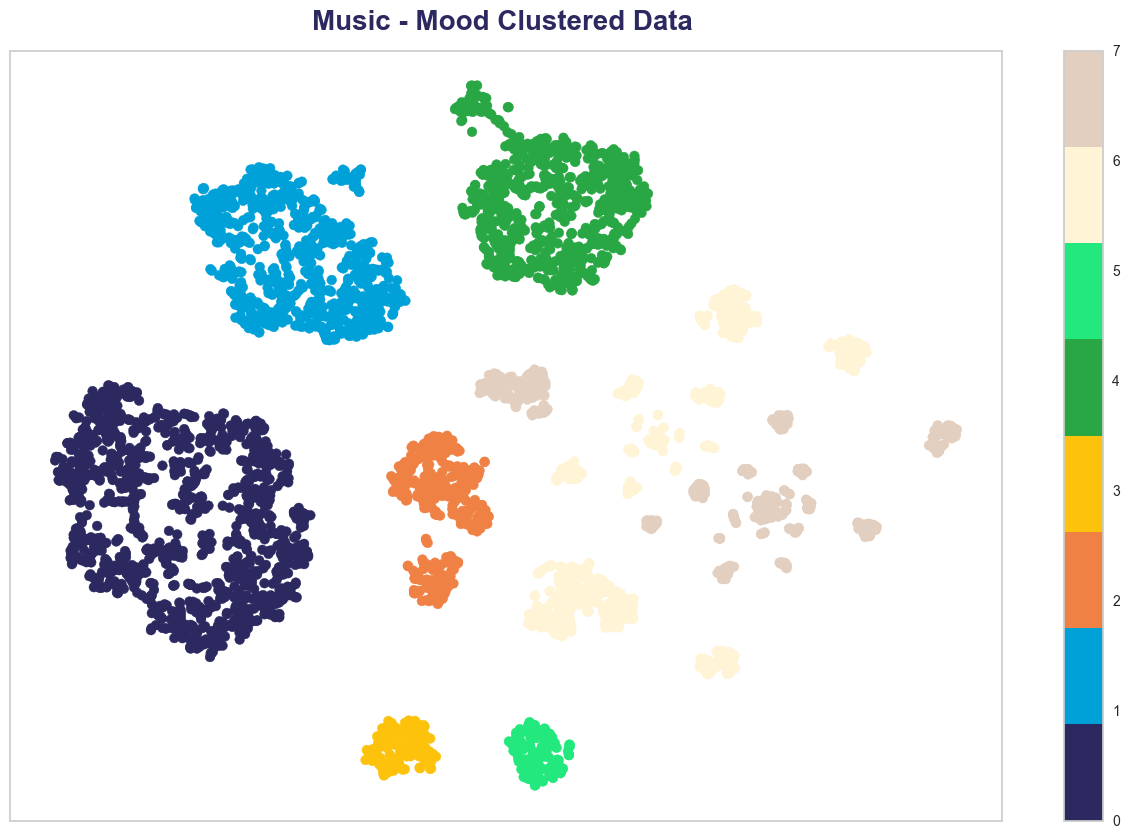

Time taken for the recommender model : 11.81 seconds
________________________________________________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________________________________________________


,track_id,track_name,artist_name
152,1jJxMXKtkD9weHJxgyXV0j,Pa Lagoon Kar Jori Re Shyam,Lata Mangeshkar
29,1ugGKlwldUL94oICQEf8oC,Escarcha,La Sonora Santanera
121,2krquSVAFCHtD9pESDQr9t,נרקומן ציבור,Meir Ariel
73,5cS2MR8ZXazew7H3W0Wpzr,Cloudbusting,Kate Bush
147,4HzvsfmN4LosvSvbn9Frtk,Preetichya Chand Raati,Hemant Kumar


Here are your mood based recommended music tracks, enjoy! 
 : None


In [76]:
user_preferences = {'mood goal': 'calm', 'preferred_genre': 'pop'}


def web_app_query(user_preferences, playlist_length = 5):
    
    composed_variables = moosic_recommender(modelling_data = modelling_data, playlist_length= playlist_length, cluster_params = main_cluster_params, 
                            pca=False, tsne=True, sample_size = 5000, user_preferences = user_preferences)

    model = composed_variables['recommendation_model']

    recommended_moosic_playlist = composed_variables['recommended_moosic_playlist']

    print(f"Here are your mood based recommended music tracks, enjoy! \n : {display(recommended_moosic_playlist)}")


    return model


model = web_app_query(user_preferences, playlist_length = 5)


# Might contain errors from here on

In [ ]:

# main model : classifier predictions?
# - modelling : clustering + classifying (ML classification modelling?)

clf_params = {
        'n_estimators': 50,
        'learning_rate': 0.01,
        'max_depth': 8
    }


def moosic_recommender2(modelling_data = modelling_data, playlist_length= 5, cluster_params = baseline_cluster_params, clf_params = clf_params,
                        pca=False, tsne=True, sample_size = 5000, user_preferences = user_preferences, *args, **kwargs):



    # data : train, test features and targets

    X_train, X_test = modelling_data['X_train'], modelling_data['X_test']
    Y_train, Y_test = modelling_data['Y_train'], modelling_data['Y_test']
    y_train, y_test = modelling_data['y_train'], modelling_data['y_test']
    
    # get dummies
    #encoded_y_train, encoded_y_test = modelling_data['encoded_y_train'], modelling_data['encoded_y_test']

    # Label encoder
    encoded_y_train, encoded_y_test = LabelEncoder().fit_transform(y_train), LabelEncoder().fit_transform(y_test)

    recommender_start_time = time.time()

    # model : clustering with mini-batch kmeans 
    clustered_data, clustered_embeddings, cluster_labels, cluster_centers = clustering_model(X_train,  pca = pca, tsne = tsne, 
                                                                        params = cluster_params, sample_size = sample_size)

    print("________"*20)
    print("________"*20)


    # model : to visualize the clustered data with t-sne
    plt.figure(figsize = (16, 10))

    scaled_embed = MinMaxScaler().fit_transform(clustered_embeddings)
    plt.scatter(scaled_embed[:, 0], scaled_embed[:, 1], c=cluster_labels, cmap=custom_cmap_hex1)

    plt.legend()
    plt.title('Music - Mood Clustered Data ', pad=15, fontsize = 20, weight = 'bold', color='#2B2960')
    plt.colorbar()

    get_axes = plt.gca()
    xax = get_axes.axes.get_xaxis()
    xax = xax.set_visible(False)

    yax = get_axes.axes.get_yaxis()
    yax = yax.set_visible(False)

    plt.show()


    # model recommender (classification/similarity and prediction/filter) part: 

    moosic_cluster_data = pd.concat([ Y_train, clustered_data['cluster_labels']], axis=1)
    moosic_cluster_data['mood_genre'] = moosic_cluster_data['mood_goal'] + ' ' + moosic_cluster_data['core_genres']


    ## track vectorization and track - to - track similarity computation

    tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
    track_mood_genre_vector = tfidf_vectorizer.fit_transform(moosic_cluster_data['mood_genre'])

    track_similarity_matrix = linear_kernel(track_mood_genre_vector, track_mood_genre_vector)
    track_similarity_data = pd.DataFrame(track_similarity_matrix, index=moosic_cluster_data['track_name'], columns=moosic_cluster_data['track_name'])
    track_similarity_data = track_similarity_data.reset_index(drop=True)
    track_similarity_data = track_similarity_data.rename_axis(None, axis=1)

    # features track_similarity_data
    tsd_features = track_similarity_data.columns.tolist()
    scored_track_data = pd.concat([moosic_cluster_data, track_similarity_data], axis=1)


    ## split moosic_cluster_data + similarity scores data into train and test

    X_clf = scored_track_data[tsd_features] 
    Y_clf = scored_track_data[['artist_name', 'track_id',  'track_name', 'mood_goal', 'core_genres']]
    y_clf = Y_clf[['mood_goal']]

    #y_clf_classes = np.unique(y_clf)
    encoded_y_clf = LabelEncoder().fit_transform(y_clf)
    y_clf['mood_label'] = encoded_y_clf


    # drop duplicate column names
    #df.rename(columns={'duplicate_column_name': 'new_column_name'}, inplace=True)
    X_clf = X_clf.loc[:,~X_clf.columns.duplicated()].copy()


    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf['mood_label'], test_size=0.25, random_state=42, shuffle=True)


    ## model : classifier
    ## - fit on X_train_clf, y_train_clf
    clf_model = XGBClassifier(**clf_params)
    clf_fitted_model = clf_model.fit(X_train_clf, y_train_clf)   
    y_predict_probs = clf_model.predict_proba(X_test_clf)
    predictions = clf_model.predict(X_test_clf)


    ## personalized computation : 
    ## - combine input text preferences on mood + genre for user - (tfidf) vectorization 
    ## - user choices to track similarty prediction and similarity score

    user_preference = " ".join(user_preferences.values())


    ## personalized computation : 
    ## - combine input text preferences on mood + genre for user - (tfidf) vectorization 
    ## - user choices to track similarty prediction and similarity score

    user_preference = " ".join(user_preferences.values())

    user_vector = tfidf_vectorizer.transform(user_preference.to_list()) # error, correct and reshape
    user_vector = user_vector.reshape(1, -1) #.reshape(-1, 1)
    print(f'test {user_vector.shape}')

    personalized_prediction = clf_model.predict(user_preference.to_list())[0] 
    user_scores = clf_model.predict_proba(user_vector) #y_user_preds # shape mismatch?
    moosic_tracks_scores = np.dot(user_scores, track_similarity_matrix)


    # query track to track similarity moosic data based on user input
    queried_user_data = scored_track_data.copy(deep = True)
    queried_user_data = (queried_user_data.query(" mood_genre == @user_preference ")).reset_index(drop=True)

    ## - sort random N mood-music tracks by predicted probability for the category entered

    moosic_randomN_idx = np.random.choice(
                            queried_user_data.index,
                            size = 5, #playlist_length,
                            replace= False #random n = 5
                            )

    recommended_moosic_playlist = queried_user_data[['track_id', 'track_name', 'artist_name']].iloc[moosic_randomN_idx]

    print(f"Here are your mood based recommended music tracks, enjoy! \n : {recommended_moosic_playlist.values}")


    recommender_end_time = time.time()
    recommender_train_time = recommender_end_time - recommender_start_time
    print(f"Time taken for the recommender model : {recommender_train_time:.2f} seconds")

    print("________"*20)
    print("________"*20)


    composed_variables = {
        
        # fitted cluster model
        'embedded_clustered_model' : scaled_embed,

        # vectors, similarity matrices and scores data
        'track_mood_genre_vector' : track_mood_genre_vector,
        'track_similarity_matrix' : track_similarity_matrix,
        'track_similarity_data' : track_similarity_data,

        'scored_track_data' : scored_track_data,

        'clf_fitted_model' : clf_fitted_model,
        'predicted_probabilities' : y_predict_probs,
        'predictions' : predictions,

        'user_vector' : user_vector,
        'personalized_prediction' : personalized_prediction,
        'user_scores' : user_scores,
        'moosic_tracks_scores' : moosic_tracks_scores,

        'user_to_track_similarity' : user_to_track_similarity,

        # recommended playlist random
        'moosic_randomn_idx' : moosic_randomn_idx,
        'recommended_moosic_playlist' : recommended_moosic_playlist,

        # data for classifier part
        'X_train_clf' : X_train_clf,
        'X_test_clf' : X_test_clf,
        'y_train_clf' : y_train_clf,
        'y_test_clf' : y_test_clf,
        }

    return composed_variables









In [ ]:


composed_variables =  moosic_recommender(modelling_data = modelling_data, playlist_length= 5, cluster_params = baseline_cluster_params, clf_params = clf_params,
                        pca=False, tsne=True, sample_size = 5000, user_preferences = {'mood goal': 'relaxed', 'preferred_genre': 'pop'})




In [ ]:
# evaluate

#encoded_y_train, encoded_y_test = modelling_data['encoded_y_train'], modelling_data['encoded_y_test']




# Hyperparameter tuning

In [ ]:

# classifier/prediction model
# hyperparameter optimization



def classifier_tuning(x_data, y_data, model_params, random_state=42, *args, **kwargs): # model_name = 'random forest',  *args, **kwargs):

    classifiers = [
        ('RandomForestClassifier', RandomForestClassifier()),
        ('XGBClassifier', XGBClassifier()),
        ('LinearSVC', LinearSVC()),
        ('MultinomialNB', MultinomialNB()),
        ('AdaBoostClassifier', AdaBoostClassifier()),
        ('GradientBoostingClassifier', GradientBoostingClassifier())
    ]

    
    cv = KFold(n_splits=3, shuffle=True, random_state=42)

    best_classifiers = {}

    for model_name, clf_model in classifiers: 

        cv_space = model_params[model_name]
        #grid_search = GridSearchCV(classifiers, param_grid, cv=cv)
        random_search = RandomizedSearchCV(clf_model, param_distributions=cv_space, n_iter=10,
                                scoring='accuracy', n_jobs=-1, cv=cv, random_state=random_state)

        random_search.fit(x_data, y_data)
        best_classifiers[model_name] = random_search.best_estimator_

        print(f"The best hyperparameters for {model_name} are: \n {random_search.best_params_}")
        print(f"The best score for {model_name} is: {random_search.best_score_}")

        scores = cross_val_score(random_search, x_data, y_data, scoring='accuracy', cv=3, n_jobs=-1)

        print( f" The {model_name} accuracy is : mean - {np.mean(scores):.3f} &  std - {np.std(scores):.3f} " )

    return best_classifiers



# tune


model_params = {
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 3, 8, 11, 20],
        'min_samples_split': [2, 5, 10]
    },
    'XGBClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [None, 3, 8, 11, 20]
    },
    'LinearSVC': {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2']
    },
    'MultinomialNB': {
        'alpha': [0.01, 0.1, 1.0],
        'fit_prior': [True, False]
    },
    'GradientBoostingClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [None, 3, 8, 11, 20]
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    },
}

#x_data = 

#y_data 

classifier_tuning(X_train, y_train['cluster_labels'], model_params, random_state=42)



# Error analysis : clustering and classification metrics


In [ ]:
# error analysis : clustering and classification metrics


def classification_metrics(ground_truth, predictions):

    score_rocauc = roc_auc_score(ground_truth.to_numpy().reshape(-1,1), predictions.to_numpy().reshape(-1,1))
    print(f"ROC of: {score_rocauc:.2f} ")

    score_acc = accuracy_score(ground_truth.to_numpy().reshape(-1,1), predictions.to_numpy().reshape(-1,1))
    print(f"ROC of: {score_acc:.2f} ")

    score_report = classification_report(ground_truth.to_numpy().reshape(-1,1), predictions.to_numpy().reshape(-1,1))
    print(f"ROC of: {score_report:.2f} ")

    score_matrix = confusion_matrix(ground_truth.to_numpy().reshape(-1,1), predictions.to_numpy().reshape(-1,1))
    print(f"ROC of: {score_matrix:.2f} ")

    score_roc = roc_curve(ground_truth.to_numpy().reshape(-1,1), predictions.to_numpy().reshape(-1,1))
    print(f"ROC of: {score_roc:.2f} ")


    scores = {
        'roc_auc_score' : score_rocauc,
        'accuracy_score' : score_acc,
        'classification_report' : score_report,
        'confusion_matrix' : score_matrix,
        'roc_curve' : score_roc,
        }
    

    return scores






In [ ]:

# evaluation of models
# - recommended music tracks based on mood and genre
# - actual music track groupings based on mood and genre

def clf_evaluation_metrics(predictions, ground_truth, playlist_length= 5, user_preferences = {'mood goal': 'relaxed', 'preferred_genre': 'hip hop'}):
    
    moosic_groups = set(ground_truth)
    n_recommended = set(predictions[:playlist_length])
    intersection = moosic_groups.intersection(n_recommended)

    # precision at recommended playlist lenght, N = 5 (top n? random?)
    precision_n = len(intersection) / playlist_length

    # recall at recommended playlist lenght, N = 5 (top n? random?)
    recall_n = len(intersection) / len(playlist_length)

    # f1_score at recommended playlist lenght, N = 5 (top n? random?)
    f1_form = 2 * (precision_n * recall_n) / (precision_n + recall_n)
    f1_score_n = [0 if (p_n + r_n)==0 else f1_form for p_n, r_n in zip(precision_n, recall_n)]

    # mean average precision (MAP) at recommended playlist lenght, N = 5 (top n? random?)
    # map_n = lambda true_items, recommended_items, n: np.mean([precision_at_n(true_items, recommended_items, i + 1) 
    #                   for i, item in enumerate(recommended_items[:n]) if item in set(true_items)]) if any(item in set(true_items) for item in recommended_items[:n]) else 0
    for i in range(playlist_length):
        if any(predictions[i]) in moosic_groups:
            map_n = np.mean([ len(intersection) for i in range(playlist_length)]) #if predictions[i] in moosic_groups ]) 
        else:
            map_n = 0


    # discounted cumulative gain (DCG) at recommended playlist lenght, N = 5 (top n? random?)
    dcg_n = sum((2 ** 1 - 1) / np.log2(i + 2) for i, track in enumerate(predictions[:playlist_length]) if track in ground_truth)

    # normalized discounted cumulative gain (NDCG) at recommended playlist lenght, N = 5 (top n? random?)
    optimal_dcg_n = sum((2 ** 1 - 1) / np.log2(i + 2) for i, track in enumerate(predictions[:playlist_length]) if track in sorted(ground_truth, reverse=True))
    ndcg_n  = [0 if optimal_dcg_n==0 else dcg_n / optimal_dcg_n]


    eval_data = {
        'user_preferences' : user_preferences,
        'playlist_length' : playlist_length,
        'predictions' : predictions,
        'ground_truth' : ground_truth,
        'moosic_groups' : moosic_groups,
        'n_recommended' : n_recommended,
        'intersection' : intersection,
        'precision_n' : precision_n,
        'recall_n' : recall_n,
        'f1_score_n' : f1_score_n,
        'map_n' : map_n,
        'dcg_n' : dcg_n,
        'optimal_dcg_n' : optimal_dcg_n,
        'ndcg_n' : ndcg_n
        }


    return eval_data







# User data - test

|  user_id  |  user_name  | preferred_genre | mood_goal | previous_choices |
|:---------:|:-----------:|:---------------:|:---------:|:----------------:|
|  m1m0h0  |  apollo  | hip hop | happy | ['new age', 'any'] |
|  m1m0h1  |  egwu | any | euphoric | ['electronic', 'tense'] |
|  m1m0h2  |  aurras   | folk | sad | ['world/traditional', 'euphoric'] |
|  m1m0h3  |  pelios  | jazz | tense | ['country', 'relaxed'] |
|  m1m0h4  |  inuaria  | metal | calm | ['blues', 'angry'] |
|  m1m0h5  |  psyche  | blues | depressed | ['any', 'happy'] |
|  m1m0h6  |  ihy  | pop | any | ['folk', 'sad'] |
|  m1m0h7  |  ova  | rock | angry | ['jazz, 'relaxed'] |
|  m1m0h8  |  thalia  | any | relaxed | ['hip hop', 'calm'] |




In [ ]:
# test

user_preferences = {'mood goal': ['relaxed', 'tense'], 'preferred_genre': ['hip hop', 'folk']}
user_test_data = pd.DataFrame([user_preferences])

user_test_data



---

#### Initial analysis of the metrics

For the mini-batch kmeans clustering with:  
* rand_score of: 0.78  means the model is good (okay) with respect to the true mood_class
* fowlkes_mallows_score of: 0.17 , bad or moderate cluster prediction by the model?
* homogeneity_score of: 0.09, low score indicates the clusters are not highly homogeneous with respect to the predicted mood_class labels 
* completeness_score of: 0.09, low score indicates that some data points of the same class are split across predicted by the model clusters 
* v_measure_score of: 0.09 , okay/bad? quality of clustering
* mutual_info_score of: 0.18, an okay level of shared information 
* adjusted_rand_score of: 0.04 , low level beyond what is expected by chance
* adjusted_mutual_info_score of: 0.09 , low/okay level of agreement beyond what is expected by chance

<br>

For the mini-batch kmeans clustering with:  
* silhouette_score of: -0.22 , negative, the clusters overlap and are not well separated
* calinski_harabasz_score of: 2729.40 , better separation between clusters? , low within-cluster variance due to high value

<br>

* rand_score measures: the similarity of the predicted clusters and the true clusters for the mood music data, 0 (not a good match/clustering) to 1 (perfect identical to true clusters) 
* fowlkes_mallows_score: the similarity of the predicted clusters and the true clusters for the mood music data, 0 (not a good match/clustering) to 1 (perfect) 
* homogeneity_score: a measure of how much each cluster contains only data points that belong to a single class
* completeness_score: a measure of how well all cluster data points that belong to the same class are assigned to the same cluster
* v_measure_score: the harmonic mean of homogeneity and completeness, a balanced measure of the quality of clusters 
* mutual_info_score: the measure of the amount of information shared between true and predicted clusters
* adjusted_rand_score: a variation of the rand index score that accounts for chance
* adjusted_mutual_info_score: a variation of the mutual info score that accounts for chance
* silhouette_score : it measures the quality of clusters by evaluating how similar each data point is to its own cluster compared to other clusters
* calinski_harabasz_score: the variance ratio criterion, it measures the cluster quality based on between-cluster and within-cluster variance



<br>

In summary, the model 

* was able to cluster 78% of the data to the right mood clusters for the music tracks based on valence and other audio features
* thus the baseline model predicted clusters is approximately 78 % similar to the actual music-mood (1-D) clusters
* also show that clusters are not well separated and a lot of music data belonging to similar clusters were not sisigned to the same ones
* the music tracks smaples seem to belong to multiple mood classes



---


In [ ]:
# similarity between the predicted and actual mood clusters
# by what percentage are they similar?
# rand index score of 0.78
# in terms of % 

RI = 0.82
RI_rate = RI * 100
print(f"The similarity rate between predicted and true clusters is {RI_rate:.2f} %")
print(f"The baseline model predicted clusters is approximately {RI_rate:.2f} % similar to the actual music-mood (1-D) clusters")



In [ ]:

# plot

# 8 basic emotions groups from lexicon-research model of emotion

moods = ['q1_b', 'q1_u', 'q2_b', 'q2_u', 'q3_b', 'q3_u',  'q4_b',  'q4_u'] 
mood_vectors = [ (0.90, 0.65), (0.62, 0.79), (0.15, 0.81), (0.38, 0.62), (0.39, 0.2), (0.16, 0.36), (0.63, 0.37), (0.92, 0.21) ]




#mood_labels = ['anxious', 'calm', 'depressed', 'energetic', 'euphoric', 'happy', 'neutral', 'sad' ]

#mood_params = [(0.281, 0.875), (0.875, 0.1), (0.024, 0.445), (0.847, 0.868), (0.745, 0.904), (1.0, 0.735), (0.469, 0.184), (0.225, 0.333)]

valence_values, energy_values = zip(*mood_vectors)

plt.figure(figsize=(10, 6))
plt.scatter(valence_values, energy_values, color=custom_palette , marker='o', s=100) #c='#2B2960'

for label, x, y in zip(moods, valence_values, energy_values):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')


plt.axvline(x=0.5, color='#00A1D8', linestyle='--', linewidth=2)
plt.axhline(y=0.5, color='#00A1D8', linestyle='--', linewidth=2)

plt.xlabel('Valence', fontsize=14, color='#2B2960', labelpad=12)
plt.ylabel('Energy', fontsize=14, color='#2B2960', labelpad=12)
plt.title('Research: 2-D Mood Indicator Features', fontsize=20, color='#2B2960', pad=15)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()




In [ ]:
# # plot: 1d moods on 2d plane plot 


# mood_1sub_quadrants = {
#     'happy': (0.875, 1.0),
#     'euphoric': (0.875, 1.0),
#     'tense': (0.875, 1.0),
#     'angry': (0.875, 1.0),
#     'depressed': (0.0, 0.125),
#     'sad': (0.125, 0.25),
#     'calm': (0.875, 1.0),
#     'relaxed': (0.875, 1.0),
# }



# mood_labels =  mood_1sub_quadrants.keys() 

# mood_params =  mood_1sub_quadrants.values()

# valence_values, energy_values = zip(*mood_params)

# #print(valence_values)
# #print(energy_values)
# #print(mood_labels)

# plt.figure(figsize=(10, 6))
# plt.scatter(valence_values, energy_values, color=custom_palette , marker='o', s=100) #c='#2B2960'

# for label, x, y in zip(mood_labels, valence_values, energy_values):
#     plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')


# plt.axvline(x=0.5, color='#00A1D8', linestyle='--', linewidth=2)
# plt.axhline(y=0.5, color='#00A1D8', linestyle='--', linewidth=2)

# plt.xlabel('Valence', fontsize=14, color='#2B2960', labelpad=12)
# plt.ylabel('Energy', fontsize=14, color='#2B2960', labelpad=12)
# plt.title('2-D Mood Indicator Features', fontsize=20, color='#2B2960', pad=15)

# plt.grid(True)
# plt.show()








In [ ]:

# #2d 

# mood_2sub_quadrants = {
#     'happy': [(0.5, 1.0), (0.5, 0.75)],
#     'euphoric': [(0.5, 1.0), (0.75, 1.0)],
#     'tense': [(0.0, 0.5), (0.75, 1.0)],
#     'angry': [(0.0, 0.5), (0.5, 0.75)],
#     'depressed': [(0.0, 0.5), (0.25, 0.5)],
#     'sad': [(0.0, 0.5), (0.0, 0.25)],
#     'calm': [(0.5, 1.0), (0.0, 0.25)],
#     'relaxed': [(0.5, 1.0), (0.25, 0.5)],
# }

# fig, ax = plt.subplots()

# for mood, ranges in mood_2sub_quadrants.items():
#     x_range, y_range = ranges
#     x_min, x_max = x_range
#     y_min, y_max = y_range
#     width = x_max - x_min
#     height = y_max - y_min
#     rectangle = plt.Rectangle((x_min, y_min), width, height, fill=False, label=mood)
#     ax.add_patch(rectangle)

# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)

# plt.xlabel('Valence', fontsize=14, color='#2B2960', labelpad=12)
# plt.ylabel('Energy', fontsize=14, color='#2B2960', labelpad=12)
# plt.title('2-D Mood Indicator Features', fontsize=20, color='#2B2960', pad=15)


# plt.axvline(x=0.5, color='#00A1D8', linestyle='--', linewidth=2)
# plt.axhline(y=0.5, color='#00A1D8', linestyle='--', linewidth=2)


# ax.legend()

# plt.grid(True)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))



# plt.show()



